# Exploring FLIM Towards Semantic Segmentation

> This notebook covers the necessary steps to experiment with a FLIM and a U-Net architecture, visualizing its activations.

We will approach the following:

- Using FLIM to learn an encoder;
- Defining and using a U-Net model for semantic segmentation of parasites;
- Loading FLIM-Encoder as U-Net encoder;
- Modifying data loaders to work with LAB images (From our experiments, convolution filters learn better features in the LAB space);
- Visualizing U-Net activations;
- Using an adaptive decoder to predict parasite masks;
- Train a network with a frozen encoder (encoder weights were not trained); We will also verify FLIM as an encoder initialization method, training it together with the decoder. Finally, we will use a learning rate scheduler to train first epochs with a lower learning rate (to avoid messing with the learned FLIM weights with an untrained decoder).
- Compute metrics from our predicted segmentation masks.

## Auxiliary methods, classes, and variables

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
from tqdm import tqdm
from typing import List, Union
import json

from PIL import ImageOps
from tifffile import imsave
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch_snippets

from skimage.color import lab2rgb

In [10]:
data_path = Path("/home/john_doe/msc/2_datasets/parasites")
orig_path = data_path / Path("all_images")
labels_path = data_path / Path("all_truelabels")
arch_json = Path(
"/home/john_doe/msc/3_repos/msc_repo/experiments/2_flim_activations/seg_parasites/arch2d_seg.json"
)
weights_path = Path(
"/home/john_doe/msc/3_repos/msc_repo/experiments/2_flim_activations/seg_parasites/new_flim/multiple_images/model"
)

In [11]:
# Reads architecture dict to define our network
with open(arch_json, "r") as json_data:
    arch_description = json.load(json_data)

In [4]:
""" From our experiments, we saw that convolutional operations
were able to extract better features on LAB Space. So we need to 
enable conversion to LAB.
"""
def _labf(x):
    if x >= 8.85645167903563082e-3:
        return x ** (0.333333333333333)
    else:
        return (841.0 / 108.0) * (x) + (4.0 / 29.0)
    
def rgb2lab(image, norm_value):
    image = np.array(image)
    image = image / norm_value
    
    labf_v = np.vectorize(_labf)
    
    new_image = np.zeros_like(image)
    
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    X = (
        0.4123955889674142161 * R
        + 0.3575834307637148171 * G
        + 0.1804926473817015735 * B
    )
    Y = (
        0.2125862307855955516 * R
        + 0.7151703037034108499 * G
        + 0.07220049864333622685 * B
    )
    Z = (
        0.01929721549174694484 * R
        + 0.1191838645808485318 * G
        + 0.9504971251315797660 * B
    )
    
    X = labf_v(X / 0.950456)
    Y = labf_v(Y / 1.0)
    Z = labf_v(Z / 1.088754)
    
    new_image[:, :, 0] = 116 * Y - 16
    new_image[:, :, 1] = 500 * (X - Y)
    new_image[:, :, 2] = 200 * (Y - Z)
    
    new_image[:, :, 0] = new_image[:, :, 0] / 99.998337
    new_image[:, :, 1] = (new_image[:, :, 1] + 86.182236) / (86.182236 + 98.258614)
    new_image[:, :, 2] = (new_image[:, :, 2] + 107.867744) / (107.867744 + 94.481682)
    
    return new_image.astype(np.float32)

In [5]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """If training with the whole dataset we must resize images
        to the same size (240, 240)"""
        # Converts to tensor and normalize [0, 255] -> [0, 1]
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with the whole dataset
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = rgb2lab(Image.open(image_path), norm_value=255)
        image = self.image_transforms(image)
        
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)
        
        # Tackles label as a two channel prediction (Background and Foreground)
        background = torch.zeros(1, label.shape[1], label.shape[2])
        foreground = torch.zeros(1, label.shape[1], label.shape[2])
        background[label == 0] = 1
        foreground[label == 1] = 1
        label = torch.cat([background, foreground], axis=0)

        return image, label

In [6]:
# Method to visualize Dataset Item (LAB)
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    img = img.permute(1, 2, 0)
    img[:,:, 0] = img[:,:, 0] * 99.998337
    img[:,:, 1] = img[:,:, 1] * (86.182236 + 98.258614) - 86.182236
    img[:,:, 2] = img[:,:, 2] * (107.867744 + 94.481682) - 107.867744
    img = lab2rgb(img)

    plt.subplot(131)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(img)
    plt.subplot(132)
    plt.yticks([]),plt.xticks([])
    plt.title("Background")
    plt.imshow(label[0], cmap="gray")
    plt.subplot(133)
    plt.yticks([]),plt.xticks([])
    plt.title("Foreground")
    plt.imshow(label[1], cmap="gray")

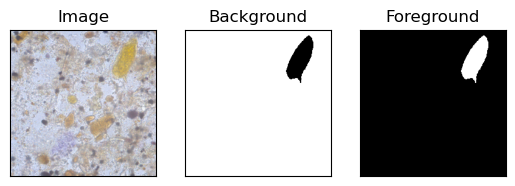

In [7]:
# Let us first verify an image (LAB) with its labels
images = os.listdir(orig_path)
images.sort()
labels = images
n_train = int((0.8 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]

# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

seg_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=0
)
sample_dataloader = DataLoader(seg_dataset, batch_size=1, shuffle=False)
train_images_sample, train_labels_sample = next(iter(sample_dataloader))

visualize_dataset_item(seg_dataset, 0)

Again, we define our code to build U-Net model and save its activations!

In [8]:
# Utilitarians blocks for UNet Decoder
# Upsamples input feature map
def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )
    
# Defines convolutional blocks for our decoder
def conv(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    
# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        
        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        self.activations_path = activations_path
        
        # Encoder Convolutional Blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=n_kernels[0],
                kernel_size=kernel_sizes[0],
                padding=kernel_sizes[0] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[0], out_channels=n_kernels[1],
                kernel_size=kernel_sizes[1],
                padding=kernel_sizes[1] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=n_kernels[1], out_channels=n_kernels[2],
                kernel_size=kernel_sizes[2],
                padding=kernel_sizes[2] // 2
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3, stride=2,
                padding=1
            )
        )
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=2, padding=bottleneck_size//2
        )
        
        # Decoder
        self.up_conv1 = up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = conv(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = conv(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.up_conv_pred = up_conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0]
        )
        self.dec_conv4 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=2, kernel_size=1
        )
        
        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.up_conv_pred.apply(init_weights)
        # Final conv before prediction
        self.dec_conv4.apply(init_weights)
        self.pred.apply(init_weights)    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}
              
        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(x1)
        self.activations["encoder"].append(x2)
        x3 = self.block3(x2)
        self.activations["encoder"].append(x3)
        
        # Bottleneck
        bottleneck = self.bottleneck(x3)
        
        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.up_conv_pred(x)
        x = self.dec_conv4(x)
        x = self.pred(x)
        
        return x
    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)
    
    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.image_transforms(
                rgb2lab(Image.open(image_path), norm_value=255)
            )
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
        
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )
                    
            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape") 
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_loss'], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(['trn_accuracy'], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load FLIM Encoder's weight into the U-Net encoder.

In [9]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")
    
    bias = np.array(bias).astype(np.float32)
    
    return bias

def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:
    kn = 1 # neutral element
    
    # Iterates over each kernel size
    for i in range(len(kernel_size)):
        kn = kn * kernel_size[i]
    
    mid_index = int(kn / 2) + 1
    
    weights = np.concatenate(
        (
            weights[in_channels: mid_index * in_channels],
            weights[0:in_channels],
            weights[mid_index * in_channels:]
        ),
        axis=0
    )
    
    return weights

def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)
    
    return weights

def load_FLIM_encoder(model: UNet, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)
    
    n_layers = arch_description["nlayers"]
    
    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"block{n}")
        
        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias
        
        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = weights.transpose()
        weights = weights.reshape(out_channels, kernel_size[1], kernel_size[0], in_channels).transpose(0, 3, 1, 2)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights
        
        in_channels = channels[n]

Then, let us load a sample weight and save our activations, to validate it against FLIM activations. They must match.

In [10]:
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=7,
    activations_path=data_path / Path("exper/flim_activations")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


In [11]:
data, label = next(iter(sample_dataloader))
data = data.to("cuda")
unet.to("cuda")
unet(data)
unet.save_activations(0, sample_dataloader)

[INFO] Saving activations!


100%|██████████| 76/76 [00:32<00:00,  2.36it/s]


## Utilitarians fuction to run train and inferences

This section implements our training loop. Also, it enables the use of a learning rate scheduler, and training with an frozen encoder.

Let us first implement our learning rate scheduler, and visualize it.

In [12]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

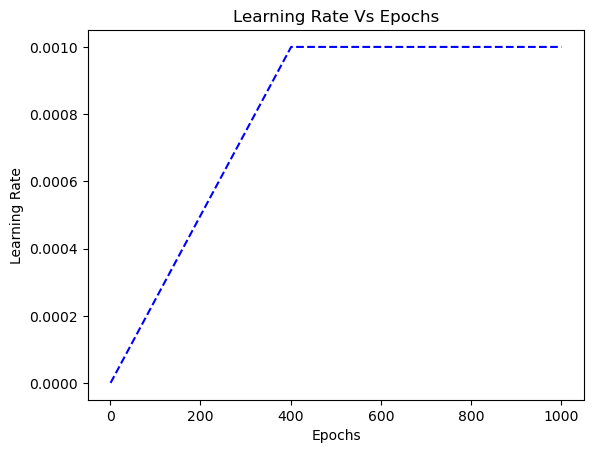

In [13]:
# create a simple model 
model = nn.Sequential(
    nn.Linear(34, 34),
    nn.ReLU(),
    nn.Linear(34, 1),
    nn.Sigmoid()
)

lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
# Start Factor of the optimizer learning rate
# End factor of the optimizer learning rate
# Total iterations to increase from Start to End Factor
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1, total_iters=400, verbose=False)

lrs = []
epochs = []

for epoch in range(1000):
    lr = scheduler.get_last_lr()
    epochs.append(epoch+1)
    lrs.append(lr)
    optimizer.step()
    scheduler.step()
    
plt.plot(epochs, lrs, "b--")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Vs Epochs")
plt.show()

Now, we define our training loop, with the followings capability:

- Freeze the Encoder's Weights
- Train with Learning Rate Scheduler

In [14]:
from torch_snippets import optim, Report
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

In [15]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(sigmoid=False, batch=False),
    "dice_focal": DiceFocalLoss()
}

class Loss(nn.Module):
    def __init__(
            self,
            loss_fn: Union[torch.nn.modules.loss, monai.losses],
            weights: List[float] = [1.0, 1.0]
        ):
        super().__init__()
        self.loss_fn = loss_fn
        self.background_weight = weights[0]
        self.foreground_weight = weights[1]

    def forward(self, y_pred, y_true):
        background_loss = self.loss_fn(y_pred[:,0, ...], y_true[:, 0, ...])
        foreground_loss = self.loss_fn(y_pred[:,1, ...], y_true[:, 1, ...])
        background_loss *= self.background_weight
        foreground_loss *= self.foreground_weight
        loss = background_loss + foreground_loss
        return loss

In [16]:
# Finaly, we define and test our training loop
# Save activations every N epochs
N_SAVE_ACTIVATIONS = 100
def train_loop(epochs, model, dataloader, lr, loss_function, weights, freeze_encoder=False, use_lr_scheduler=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-2, end_factor=1, total_iters=50, verbose=False)
    model.to("cuda")
    
    # Freeze encoder weights
    if freeze_encoder:
        model.block1.requires_grad_(False)
        model.block1.trainable = False
        model.block2.requires_grad_(False)
        model.block2.trainable = False
        model.block3.requires_grad_(False)
        model.block3.trainable = False
    
    logger = Report(epochs)
    loss = Loss(loss_function, weights)

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = nn.functional.sigmoid(prediction)
            loss_value = loss(prediction, ground_truth)

            accuracy = (
                (prediction[:,1,...] > prediction[:,0,...]) == ground_truth[:,1,...]
            ).float().mean()
            
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()
        
        # At the end of the epoch, we tach a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % N_SAVE_ACTIVATIONS) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

In [17]:
# We also define a method for prediction and evaluation
# This code gets the trained model and execute inferences on the Dataloader
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

@torch.no_grad()
def predict_and_evaluate(
        model: UNet, 
        data_loader:torch.utils.data.dataloader.DataLoader,
        subset_
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.activations_path / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)
    
    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=1, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(
                rgb2lab(Image.open(image_path), norm_value=255)
            )
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data)
        prediction = nn.functional.sigmoid(prediction)
        
        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((240, 240), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy()
        mask[(prediction[0,1,...] > prediction[0,0,...])] = 1
        
        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        dice = binary.dc(mask, ground_truth)
        dices.append(dice)
        iou = jaccard_index(torch.Tensor(mask), torch.Tensor(ground_truth))
        ious.append((iou.numpy()))
        
        cv2.imwrite(
            str(path_to_save), mask * 255
        )
    
    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)
    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")
    
    nan_index = np.argwhere(np.isnan(ious))
    accuracies = np.delete(accuracies, nan_index)
    dices = np.delete(dices, nan_index)
    ious = np.delete(ious, nan_index)
    
    print(f"[INFO - Without NaN] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO - Without NaN] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO - Without NaN] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

## Now, we load our FLIM encoder and execute the following experiments (Training with 80% of data, and testing on 20%):

- Froozen encoder
- LR Fixed
- LR Scheduler

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 0.806  trn_accuracy: 0.973  (3.69s - 364.98s remaining)
EPOCH: 2.000  trn_loss: 0.690  trn_accuracy: 0.979  (7.01s - 343.56s remaining)
EPOCH: 3.000  trn_loss: 0.597  trn_accuracy: 0.995  (10.34s - 334.19s remaining)
EPOCH: 4.000  trn_loss: 0.532  trn_accuracy: 0.997  (13.77s - 330.50s remaining)
EPOCH: 5.000  trn_loss: 0.485  trn_accuracy: 0.997  (17.17s - 326.25s remaining)
EPOCH: 6.000  trn_loss: 0.446  trn_accuracy: 0.997  (20.62s - 322.98s remaining)
EPOCH: 7.000  trn_loss: 0.412  trn_accuracy: 0.997  (24.25s - 322.13s remaining)
EPOCH: 8.000  trn_loss: 0.378  trn_accuracy: 0.998  (27.87s - 320.55s remaining)
EPOCH: 9.000  trn_loss: 0.348  trn_accuracy: 0.999  (31.54s - 318.90s remaining)
EPOCH: 10.000  trn_loss: 0.321  trn_accuracy: 0.999  (35.25s - 317.27s remaining)
EPOCH: 11.000  trn_loss: 0.297  trn_accuracy: 1.000  (38.93s - 315.02s

100%|██████████| 201/201 [00:00<00:00, 76523.11it/s]


[INFO] Training Metrics


76it [00:04, 17.91it/s]


[INFO] Avg Accuracy: 0.9990614056587219 +/- 0.0010094798635691404
[INFO] Avg Dice: 0.518661663250087 +/- 0.47930571057613325
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9982600212097168 +/- 0.0007034224108792841
[INFO - Without NaN] Avg Dice: 0.9614216196830879 +/- 0.013012663886167317
[INFO - Without NaN] Avg IoU: 0.9260083436965942 +/- 0.023880695924162865
[INFO] Test Metrics


20it [00:01, 16.47it/s]


[INFO] Avg Accuracy: 0.994805634021759 +/- 0.0062004257924854755
[INFO] Avg Dice: 0.3728949882293975 +/- 0.39951095438438194
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9925794005393982 +/- 0.006196944508701563
[INFO - Without NaN] Avg Dice: 0.5327071260419964 +/- 0.3779944395369098
[INFO - Without NaN] Avg IoU: 0.45076489448547363 +/- 0.3440389931201935


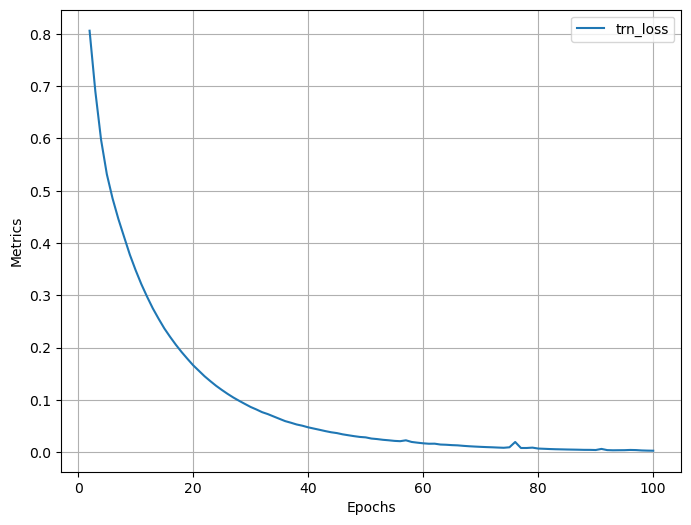

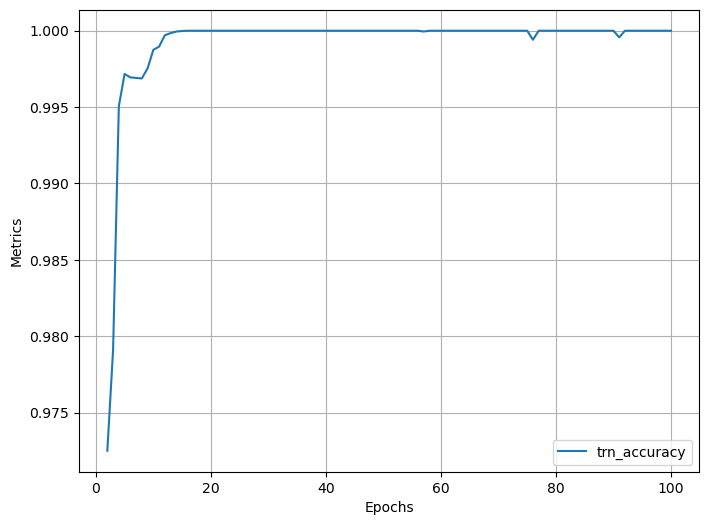

In [18]:
# Train with the Whole Train Dataset
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_ENC_whole_data_frozen_encoder")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=100,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=True,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 0.805  trn_accuracy: 0.973  (3.73s - 369.68s remaining)
EPOCH: 2.000  trn_loss: 0.688  trn_accuracy: 0.980  (7.26s - 355.85s remaining)
EPOCH: 3.000  trn_loss: 0.592  trn_accuracy: 0.998  (10.86s - 351.17s remaining)
EPOCH: 4.000  trn_loss: 0.526  trn_accuracy: 0.999  (14.55s - 349.25s remaining)
EPOCH: 5.000  trn_loss: 0.481  trn_accuracy: 0.998  (18.47s - 350.92s remaining)
EPOCH: 6.000  trn_loss: 0.441  trn_accuracy: 0.998  (22.64s - 354.66s remaining)
EPOCH: 7.000  trn_loss: 0.406  trn_accuracy: 0.999  (26.82s - 356.36s remaining)
EPOCH: 8.000  trn_loss: 0.373  trn_accuracy: 0.999  (30.92s - 355.58s remaining)
EPOCH: 9.000  trn_loss: 0.344  trn_accuracy: 1.000  (34.82s - 352.04s remaining)
EPOCH: 10.000  trn_loss: 0.319  trn_accuracy: 1.000  (38.78s - 349.02s remaining)
EPOCH: 11.000  trn_loss: 0.295  trn_accuracy: 1.000  (42.52s - 344.01s

100%|██████████| 201/201 [00:00<00:00, 45379.22it/s]


[INFO] Training Metrics


76it [00:04, 17.86it/s]


[INFO] Avg Accuracy: 0.9986218810081482 +/- 0.0015792149351909757
[INFO] Avg Dice: 0.5038958786714497 +/- 0.46682329194256017
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9974454641342163 +/- 0.00127178686670959
[INFO - Without NaN] Avg Dice: 0.9340508970495165 +/- 0.04658300123461392
[INFO - Without NaN] Avg IoU: 0.8796112537384033 +/- 0.07673715800046921
[INFO] Test Metrics


20it [00:01, 16.69it/s]


[INFO] Avg Accuracy: 0.9956318736076355 +/- 0.004649635404348373
[INFO] Avg Dice: 0.4076208926244271 +/- 0.419932823706193
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9937599897384644 +/- 0.00438210554420948
[INFO - Without NaN] Avg Dice: 0.5823155608920387 +/- 0.3875460890745486
[INFO - Without NaN] Avg IoU: 0.5072882175445557 +/- 0.35658133029937744


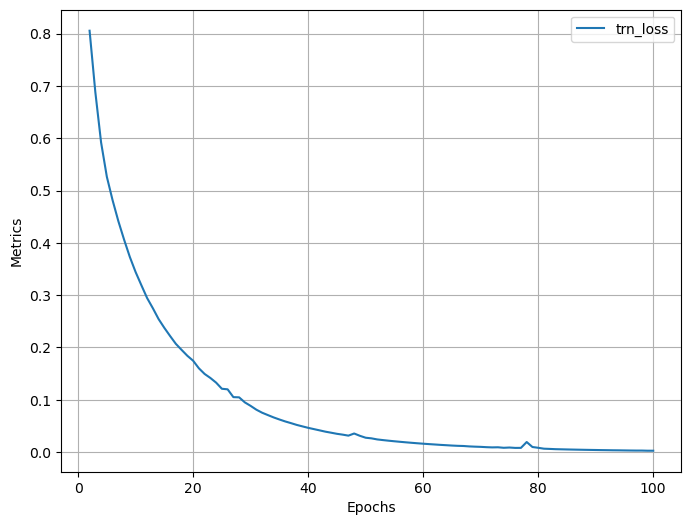

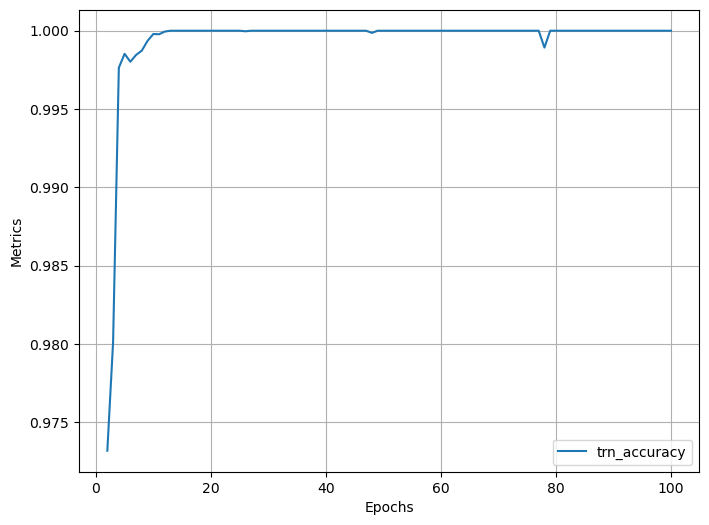

In [19]:
# Train with the Whole Train Dataset
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_ENC_whole_data_fixed_lr")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=100,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=False
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 1.213  trn_accuracy: 0.752  (3.55s - 707.36s remaining)
EPOCH: 2.000  trn_loss: 1.155  trn_accuracy: 0.812  (7.67s - 759.29s remaining)
EPOCH: 3.000  trn_loss: 1.079  trn_accuracy: 0.856  (11.61s - 762.16s remaining)
EPOCH: 4.000  trn_loss: 1.019  trn_accuracy: 0.894  (15.69s - 769.04s remaining)
EPOCH: 5.000  trn_loss: 0.968  trn_accuracy: 0.924  (19.63s - 765.54s remaining)
EPOCH: 6.000  trn_loss: 0.923  trn_accuracy: 0.945  (23.51s - 760.28s remaining)
EPOCH: 7.000  trn_loss: 0.880  trn_accuracy: 0.962  (27.32s - 753.25s remaining)
EPOCH: 8.000  trn_loss: 0.840  trn_accuracy: 0.977  (31.10s - 746.28s remaining)
EPOCH: 9.000  trn_loss: 0.802  trn_accuracy: 0.987  (35.07s - 744.36s remaining)
EPOCH: 10.000  trn_loss: 0.767  trn_accuracy: 0.992  (39.59s - 752.19s remaining)
EPOCH: 11.000  trn_loss: 0.733  trn_accuracy: 0.997  (43.89s - 754.12s

100%|██████████| 76/76 [00:28<00:00,  2.71it/s]


EPOCH: 101.000  trn_loss: 0.009  trn_accuracy: 1.000  (439.06s - 430.36s remaining)
EPOCH: 102.000  trn_loss: 0.009  trn_accuracy: 1.000  (442.69s - 425.33s remaining)
EPOCH: 103.000  trn_loss: 0.008  trn_accuracy: 1.000  (446.50s - 420.49s remaining)
EPOCH: 104.000  trn_loss: 0.008  trn_accuracy: 1.000  (450.26s - 415.63s remaining)
EPOCH: 105.000  trn_loss: 0.007  trn_accuracy: 1.000  (454.13s - 410.88s remaining)
EPOCH: 106.000  trn_loss: 0.007  trn_accuracy: 1.000  (458.02s - 406.17s remaining)
EPOCH: 107.000  trn_loss: 0.006  trn_accuracy: 1.000  (462.40s - 401.90s remaining)
EPOCH: 108.000  trn_loss: 0.006  trn_accuracy: 1.000  (466.19s - 397.12s remaining)
EPOCH: 109.000  trn_loss: 0.006  trn_accuracy: 1.000  (469.98s - 392.37s remaining)
EPOCH: 110.000  trn_loss: 0.006  trn_accuracy: 1.000  (473.83s - 387.68s remaining)
EPOCH: 111.000  trn_loss: 0.005  trn_accuracy: 1.000  (477.60s - 382.94s remaining)
EPOCH: 112.000  trn_loss: 0.005  trn_accuracy: 1.000  (481.89s - 378.63s rem

100%|██████████| 301/301 [00:00<00:00, 39442.81it/s]


[INFO] Training Metrics


76it [00:05, 15.18it/s]


[INFO] Avg Accuracy: 0.9993637204170227 +/- 0.0006414337549358606
[INFO] Avg Dice: 0.5246631801831946 +/- 0.4848088899172102
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9988206028938293 +/- 0.0003495700948406011
[INFO - Without NaN] Avg Dice: 0.9725463827786045 +/- 0.009802200100981123
[INFO - Without NaN] Avg IoU: 0.9467355608940125 +/- 0.018422696739435196
[INFO] Test Metrics


20it [00:01, 15.62it/s]


[INFO] Avg Accuracy: 0.9966527819633484 +/- 0.003098865272477269
[INFO] Avg Dice: 0.4307664669914752 +/- 0.4339160155810129
[INFO] Avg IoU: nan +/- nan
[INFO - Without NaN] Avg Accuracy: 0.9952181577682495 +/- 0.002618968952447176
[INFO - Without NaN] Avg Dice: 0.6153806671306788 +/- 0.3941672991931941
[INFO - Without NaN] Avg IoU: 0.5457119345664978 +/- 0.3578896224498749


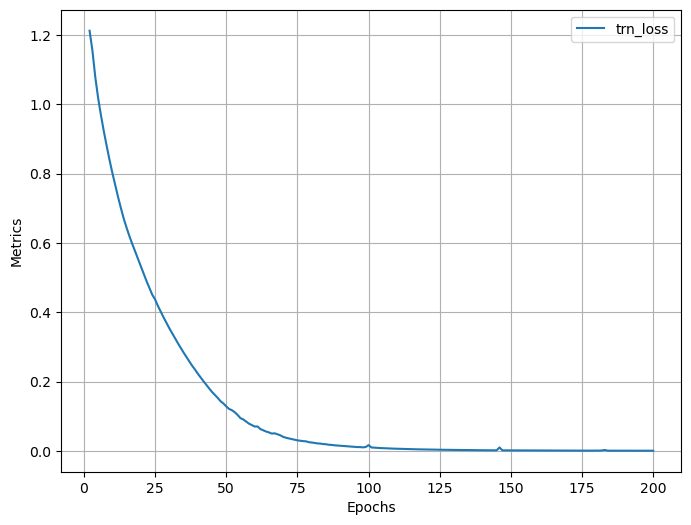

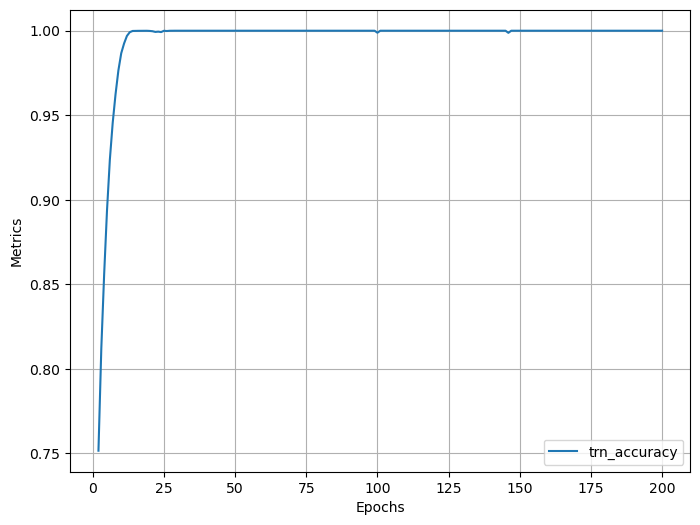

In [20]:
# Train with the Whole Train Dataset
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# Test on whole test set
test_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=test_images,
    labels=test_labels,
    image_id=None
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=3,
    activations_path=data_path / Path("exper/FLIM_ENC_whole_data_lr_scheduler")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

train_loop(
    epochs=200,
    model=unet,
    dataloader=train_dataloader,
    lr=1e-4,
    loss_function=loss_fuctions["bce"],
    weights=[1, 1], # Classes weights (Background and Foreground)
    freeze_encoder=False,
    use_lr_scheduler=True
)
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

## Adaptive Decoder

Lastly, we will see an approach that requires only the FLIM-Encoders. Based on the learned encoders, we propose an adaptive decoder, which combines activations (foreground and background) to enable segmentation.

The proposed approach implements the following:

1. For each FLIM-encoder activation, we apply a weighted sum (given background: -1 or foreground: 1);
2. Starting from the lowest encoder block (The smallest one), we get the bounding box of the most significant connected component (i.e., largest contour after binarization);
3. We scale the coordinate of the detected component to the upper encoder block (2x Scale). We zero the activations out of the bounding box;
4. We repeat step 3 until we reach the first FLIM-Encoder block and get the accurate parasite delineation.

This approach enables us to use the last and intermediary encoder blocks to detect the parasite and the first block to delineate the parasite. Hence, the previous layers' boundings boxes enable us to eliminate false positive activations on encoders' first blocks.

For that, we will use an U-Net with FLIM-Encoder loaded.

In [92]:
train_dataset = SegDataset(
    images_path=orig_path,
    labels_path=labels_path,
    images=train_images,
    labels=train_labels,
    image_id=None
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Defines model to train
unet = UNet(
    in_channels=3,
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    bottleneck_size=7,
    activations_path=data_path / Path("exper/FLIM_ENC_adaptive_dec")
)
load_FLIM_encoder(
    model=unet,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


In [93]:
def get_conv_weights(weights_path: PosixPath) -> np.ndarray:
    with open(weights_path, "r") as file:
        n_weights = file.readline()
        weights = file.readline().strip().split(" ")
    
    weights = np.array(weights).astype(np.float32)
    weights = weights[:,np.newaxis, np.newaxis]
    
    return weights

In [136]:
image_data = train_dataloader.dataset.image_transforms(
        rgb2lab(Image.open(train_dataloader.dataset.images_path[0]), norm_value=255)
    )
ground_truth = train_dataloader.dataset.label_transforms(
    ImageOps.grayscale(Image.open(train_dataloader.dataset.labels_path[0]))
)
ground_truth = ground_truth.cpu().detach().numpy()[0]
image_data = torch.unsqueeze(image_data, dim=0)
image_data = image_data.to("cuda")

# Read activations weights for decoding - Weights são inuteis
conv1_weights = get_conv_weights(weights_path / Path("conv1-weights.txt"))
conv2_weights = get_conv_weights(weights_path / Path("conv2-weights.txt"))
conv3_weights = get_conv_weights(weights_path / Path("conv3-weights.txt"))

In [137]:
def plot_adaptive_decoder(summed_activation, summed_activation_bin, drawn_img, title):
    plt.subplot(131)
    plt.imshow(summed_activation, cmap="gray")
    plt.yticks([]),plt.xticks([])
    plt.title(f"{title}: Activation")
    plt.subplot(132)
    plt.imshow(summed_activation_bin, cmap="gray")
    plt.yticks([]),plt.xticks([])
    plt.title(f"{title}: Binary Activation")
    plt.subplot(133)
    plt.imshow(drawn_img, cmap="gray")
    plt.yticks([]),plt.xticks([])
    plt.title(f"{title}: Detected Contour")
    plt.show()
    
    
    #plt.title("Image")
    #plt.imshow(img)
    #plt.subplot(132)
    #plt.title("Background")

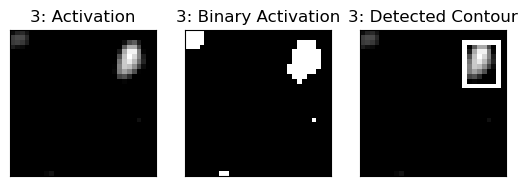

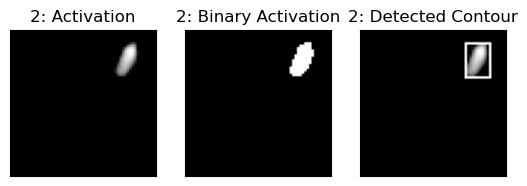

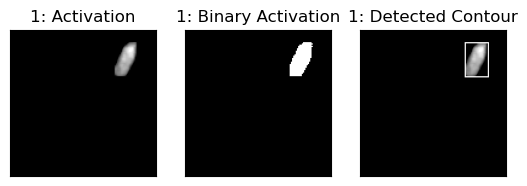

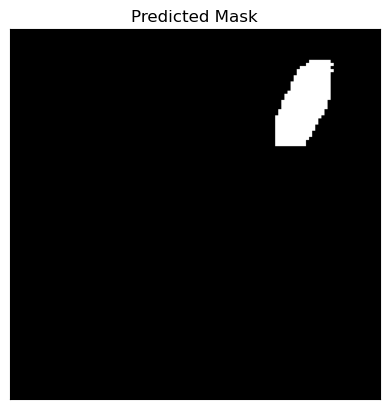

[INFO] Accuracy: 0.9673784971237183
[INFO] Dice: 0.8521686010995724
[INFO] IoU: 0.7424162030220032


In [142]:
# Generate Model Activations
unet.to("cuda")
unet(image_data)
encoder_activations = unet.activations["encoder"]

for idx, (activations, weights) in enumerate(zip(encoder_activations[::-1], [conv3_weights, conv2_weights, conv1_weights])):
    activations = activations.detach().cpu().numpy()[0]
    activations = activations * weights
    
    summed_activation = np.sum(activations, axis=0)
    
    # Zero out negative values
    summed_activation[summed_activation < 0] = 0
    
    # Normalizes between 0 and 255
    max_value = np.max(summed_activation)
    min_value = np.min(summed_activation)
    summed_activation = 255 * (summed_activation - min_value) / (max_value - min_value)
    summed_activation = summed_activation.astype(np.uint8)
    
    # If Idx greater than 0 - Zero out activations based on detected contour
    if idx > 0:
        # Scale bounding box coordinates
        x_initial *= 2
        x_final *= 2
        y_initial *= 2
        y_final *= 2
        tmp_array = np.zeros_like(summed_activation)
        tmp_array[y_initial:y_final, x_initial:x_final] = summed_activation[y_initial:y_final, x_initial:x_final]
        summed_activation = tmp_array
    
    # Binarizes image
    summed_activation_bin = summed_activation.copy()
    summed_activation_bin[summed_activation_bin > 0.5] = 255
    
    # Get largest contour
    contours, hierarchy = cv2.findContours(summed_activation_bin,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key = cv2.contourArea)
    x_initial, y_initial, width, height = cv2.boundingRect(contour)
    x_final = x_initial + width
    y_final = y_initial + height
    drawn_img = summed_activation.copy()
    drawn_img = cv2.rectangle(
        drawn_img, (x_initial, y_initial), 
        (x_final, y_final), (255,255,255), 1
    )
    
    plot_adaptive_decoder(summed_activation, summed_activation_bin, drawn_img, title=f"{3 - idx}")
    
final_prediction = cv2.resize(summed_activation, dsize=(240, 240), interpolation=cv2.INTER_NEAREST)
# Scale final bounding box
x_initial *= 2
x_final *= 2
y_initial *= 2
y_final *= 2

# Zero out activations outside final bounding box
tmp_array = np.zeros_like(final_prediction)
tmp_array[y_initial:y_final, x_initial:x_final] = final_prediction[y_initial:y_final, x_initial:x_final]
final_prediction = tmp_array
final_prediction[final_prediction > 0] = 255

plt.imshow(final_prediction, cmap="gray")
plt.yticks([]),plt.xticks([])
plt.title("Predicted Mask")
plt.show()

# Computes metrics
jaccard_index = JaccardIndex(num_classes=1, task="binary")
accuracy = np.mean((final_prediction == ground_truth).astype(np.float32))
dice = binary.dc(final_prediction, ground_truth)
iou = jaccard_index(torch.Tensor(final_prediction), torch.Tensor(ground_truth))

print(f"[INFO] Accuracy: {accuracy}")
print(f"[INFO] Dice: {dice}")
print(f"[INFO] IoU: {iou}")

## Extra - Activities

- Try different loses and Classes weights (weights parameter on train_loop). Could you increase performance metrics?
- Try to improve the adaptive decoder. Could you implement any modification which increases perfomance metrics?
- Could you apply post-processing on predicted masks to increase performance metrics (e.g., morphological operations)?
- Could you replicate the adaptive decoder to the whole dataset?